In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [34]:
import torch.nn.functional as F

In [65]:
import datetime

In [70]:
writer = SummaryWriter(f"../../runs/mnist_{datetime.datetime.now().strftime('%Y-%m-%d_%H_%M_%S')}/")

In [71]:
# device config:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [72]:
# MNIST 
train_dataset = torchvision.datasets.MNIST(root='../../data/mnist/',train=True,transform=transforms.ToTensor(),download=False)

In [73]:
test_dataset = torchvision.datasets.MNIST(root='../../data/mnist/',train=False, transform=transforms.ToTensor())

In [74]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [75]:
examples = iter(train_loader)
samples,labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [76]:
labels[0]

tensor(5)

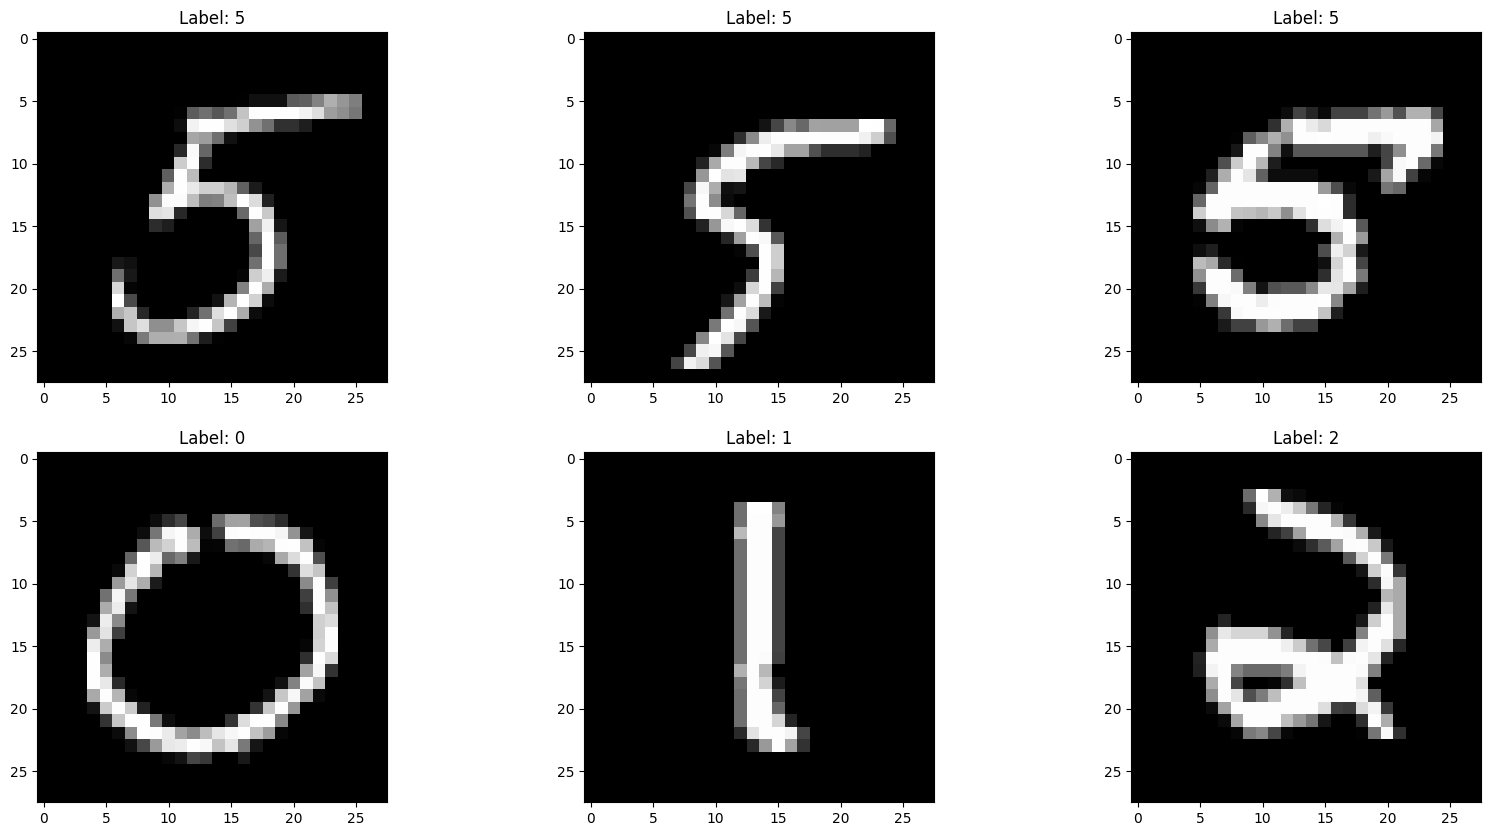

In [77]:
counter= 0
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i in range(2):
    for j in range(3):
        image = samples[counter]
        image = torch.permute(image,(1,2,0))
        image = torch.squeeze(image)
        ax[i,j].imshow(image.clone().numpy(),cmap="gray")
        ax[i,j].set_title(f"Label: {labels[counter].item()}")
        counter+=1

In [78]:
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images',img_grid)
writer.close()

In [79]:
img_grid.shape

torch.Size([3, 392, 242])

Adding a Projector to tensorboard:
- we can visualise the lower dimensional representation of higher dimensional data via the add_embedding method

In [80]:
z = torch.randperm(100)

In [81]:
z

tensor([58, 83, 32, 98, 22, 71, 48, 82, 56, 65,  6, 35, 94, 18,  2, 59,  3, 51,
        72, 46, 33, 52, 67, 77, 41, 55, 12, 13, 76, 97, 57, 34, 66, 80,  1, 49,
        73,  0, 44, 38,  8, 50, 90, 93, 29, 11, 47, 79, 40, 42, 78, 68, 36, 62,
        85, 39, 69,  4, 20, 45, 81, 70,  7, 15, 14, 53, 43, 30, 63, 95, 86,  9,
        21, 64, 37, 88, 61, 96, 25, 91, 99, 27, 16, 10, 23, 87, 75, 60, 19, 89,
        84, 24, 31, 54, 28, 17,  5, 92, 26, 74])

In [82]:
d = torch.randn(100,30)

In [83]:
d[z]

tensor([[ 0.2419, -0.6520,  0.0979,  ..., -0.1778,  0.3538, -1.2872],
        [-0.8060,  0.1008, -1.8162,  ...,  0.3548,  0.0281, -2.4568],
        [-0.8402, -0.1663, -0.4022,  ...,  0.8838,  0.4848,  0.6860],
        ...,
        [-0.1281,  1.8852,  1.4618,  ...,  1.4348, -0.1266, -1.9503],
        [-0.0910,  0.6856, -0.9418,  ..., -1.4247,  0.7244,  0.1872],
        [-0.8563, -0.7479,  0.4511,  ...,  0.6213, -0.0964, -0.7210]])

In [84]:
# helper function
def select_n_random(data,labels,n=100):
    '''
        Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n],labels[perm][:n]

# select random images and their target indices
imgs, lbs = select_n_random(samples,labels)


In [85]:
imgs.shape

torch.Size([100, 1, 28, 28])

In [86]:
imgs.unsqueeze(1).shape

torch.Size([100, 1, 1, 28, 28])

In [87]:
classes = ["Zero","One","Two","Three","Four","Five","Six","Seven","Eight","Nine"]

In [88]:
# get the class labels for each image
class_labels = [classes[lab] for lab in lbs]

In [89]:
# log embeddings
features = imgs.view(-1,28*28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=imgs,
                     global_step=0)
writer.close()

Classify the digits:

In [13]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        nn.init.kaiming_normal_(self.l1.weight)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        nn.init.xavier_normal_(self.l2.weight)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [21]:
model = NeuralNet(input_size, hidden_size, num_classes)
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
writer.add_graph(model,samples.reshape(-1,784))
writer.close()

In [24]:
import datetime

In [28]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2025-10-13 15:38:32'

In [ ]:
# training loop
n_total_steps = len(train_loader)
running_loss = 0.0
running_correct = 0

run_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

train

for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images = images.view(-1,784).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)

        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_loss+=loss.item()
        predicted = torch.argmax(outputs,dim=1)
        running_correct += (predicted == labels).sum().item()

        with torch.no_grad():
            if (i+1)%100 == 0:
                train_acc = (torch.argmax(outputs,dim=1) == labels).sum().item()/labels.shape[0]
                t_loss_sum = 0
                t_acc_sum = 0
                for j, (t_images,t_labels) in enumerate(test_loader):
                    t_images = t_images.view(-1, 784).to(device)
                    t_labels = t_labels.to(device)
                    t_outputs = model(t_images)
                    t_loss = criterion(t_outputs,t_labels)
                    t_loss_sum += t_loss.item()*t_images.shape[0]
                    t_acc_sum += (torch.argmax(t_outputs, dim=1) == t_labels).sum().item()
                t_loss_sum = t_loss_sum/len(test_dataset)
                t_acc_sum = t_acc_sum/len(test_dataset)
                print(f"Epoch: {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, train_loss = {loss.item():.4f}, test_loss: {t_loss_sum:.4f}, train_acc: {train_acc:.4f}, test_acc: {t_acc_sum:.4f}")

                writer.add_scalar(f'train_loss_{run_time}', loss.item(),epoch*n_total_steps+i)
                writer.add_scalar(f'train_acc_{run_time}', train_acc,epoch*n_total_steps+i)


Epoch: 1/2, step 100/600, train_loss = 0.4652, test_loss: 0.3908, train_acc: 0.8700, test_acc: 0.8891
Epoch: 1/2, step 200/600, train_loss = 0.2962, test_loss: 0.3084, train_acc: 0.9000, test_acc: 0.9115
Epoch: 1/2, step 300/600, train_loss = 0.2028, test_loss: 0.2600, train_acc: 0.9300, test_acc: 0.9269
Epoch: 1/2, step 400/600, train_loss = 0.2596, test_loss: 0.2314, train_acc: 0.9400, test_acc: 0.9334
Epoch: 1/2, step 500/600, train_loss = 0.2465, test_loss: 0.2205, train_acc: 0.9200, test_acc: 0.9356
Epoch: 1/2, step 600/600, train_loss = 0.1590, test_loss: 0.1990, train_acc: 0.9700, test_acc: 0.9422
Epoch: 2/2, step 100/600, train_loss = 0.1412, test_loss: 0.1835, train_acc: 0.9400, test_acc: 0.9492
Epoch: 2/2, step 200/600, train_loss = 0.1953, test_loss: 0.1711, train_acc: 0.9600, test_acc: 0.9517
Epoch: 2/2, step 300/600, train_loss = 0.0790, test_loss: 0.1620, train_acc: 0.9800, test_acc: 0.9545
Epoch: 2/2, step 400/600, train_loss = 0.4114, test_loss: 0.1545, train_acc: 0.930

In [29]:
z = torch.randn(100,10)

In [35]:
z_emb = [F.softmax(output, dim=0) for output in z]

In [42]:
z_emb = torch.stack(z_emb)

In [39]:
y_emb = torch.randn(100,10)

In [44]:
torch.cat((z_emb,y_emb)).shape

torch.Size([200, 10])

In [32]:
counter=0
for row in z:
    counter+=1

In [33]:
counter

100